# The Transformation and Accept/Reject (aka. Von Neumann) methods 
Python notebook with exercise on how to generate random numbers following a specific PDF using uniformly distributed random numbers, in this case a third degree polynomial: $f(x) = x^3$, in the interval $[0, C]$ where $C$ is a number that ensures that the function if properly normalized.

Both the Accept-Reject (Von Neumann) and transformation method should be considered for the problem:
- Transformation method (if function can be integrated and then inverted).
- Accept-Reject (or Hit & Miss) method (by Ulam Stanislav and John Von Neumann).

### References:
- G. Cowan: Chapter 3
- P. R. Bevington: page 81-84
- __[40. Monte Carlo Techniques PDG](http://pdg.lbl.gov/2020/reviews/rpp2020-rev-monte-carlo-techniques.pdf)__

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 29-11-2022 (latest update)

***

In [55]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats

Load external functions:

In [56]:
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

set the parameters of the program:

In [57]:
r = np.random
r.seed(42)

save_plots = False  
N_points = 10000      # Number of random points used 

C = np.sqrt(2)
xmin = 1
xmax = C         # Find out yourself what a good interval is.
N_bins = 140          # Find out yourself what a good number of bins is.

# f(x):
def fx_x3(x) :
    return np.power(x, 3)

In [58]:
# Construct transformation values in accordance with problem 1) and 2)
C = np.sqrt(2)
if xmin == 0:
    x_transformation = xmin + (xmax - xmin) * np.power(r.rand(N_points), 0.25)
if xmin == 1:
    x_transformation =  np.power(4 * r.rand(N_points) + 1, 0.25)

x_accepted = np.empty(1)
N_try = int(2 * N_points)
N_accum = N_try

while x_accepted.size < N_points:
    # Construct N_points points by accepting/rejecting without the horrible while loop

    ## First, we construct 2.5 * N_points uniform random values in [0,C]:
    r_vals = C * r.rand(N_try)
    ## Next, we construct another set of uniform random values in [0,fmax = C**3]
    u_vals = C ** 3 * r.rand(N_try)
    ## Finally, we keep only the r_vals values satisfying u_vals < fx_x3 (r_vals)
    mask = (u_vals < fx_x3(r_vals))
    x_accepted       = np.r_['0', x_accepted, r_vals[mask]]

    N_try = int(3 * (N_points - x_accepted.size))
    N_accum += N_try

    if x_accepted.size > N_points:
        x_accepted = x_accepted[:N_points]

efficiency = N_points / N_accum
eff_err = np.sqrt(efficiency*(1-efficiency) / N_accum)
print("efficiency: ", f'{efficiency:6.3f}', "\u00B1 ", f'{eff_err:6.3f}')


efficiency:   0.252 ±   0.002


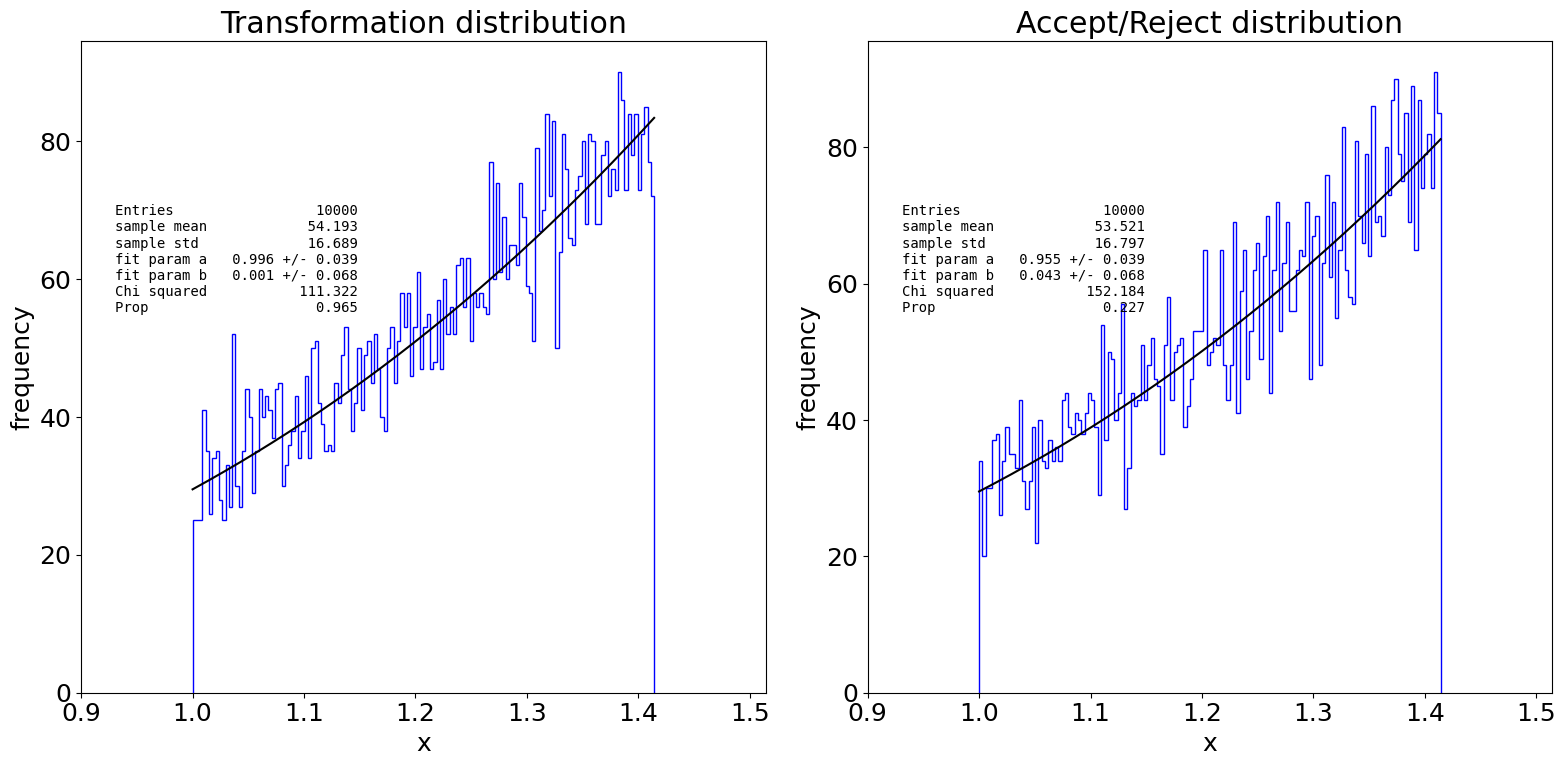

In [60]:
## Fit both distributions

def fit_func (x, a, b):
     # Scale function
    bin_width = (xmax - xmin) / N_bins
    scaling = N_points * bin_width
    return scaling * (a * x ** 3 + b)


fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
ax = ax.flatten()

values = [x_transformation, x_accepted]
names = ['Transformation distribution', 'Accept/Reject distribution']

for i, val in enumerate(values):
    counts, edges, _ = ax[i].hist(val, range = (xmin, xmax), bins = N_bins, histtype = 'step', color = 'blue')
    ax[i].set(xlim = (xmin-0.1,xmax+0.1), ylabel = f'frequency', xlabel = 'x', title = names[i])

    x_vals = 0.5 * ( edges[:-1] + edges[1:])
    y_vals = counts
    y_err = np.sqrt(counts)
    mask = (y_vals > 0)
    N_non_empty = len(mask)

    chi2_object = Chi2Regression(fit_func, x_vals[mask], y_vals[mask], y_err[mask])
    chi2_object.errordef = 1

    fit = Minuit(chi2_object, a = 2, b = 0)
    fit.migrad()

    # Plot fit
    x_range = np.linspace(xmin, xmax, 1000)

   
    scaling = 1
    fit_vals =  fit_func(x_range, *fit.values[:])

    ax[i].plot(x_range, fit_vals, 'k-')

    # Get statistics
    Ndof = len(y_vals[mask])
    chi2 = fit.fval
    prop = stats.chi2.sf(chi2, Ndof)
    d = {"Entries": N_points, "sample mean ": y_vals.mean(), "sample std ": y_vals.std(ddof = 1), "fit param a": [fit.values['a'],fit.errors['a']] ,
            "fit param b": [fit.values['b'],fit.errors['b']], "Chi squared": chi2, "Prop": prop}

    # Plot figure text
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.05, 0.75, text, ax[i], fontsize=10)


    fig.tight_layout()


## Problem: 

1) Calculate $C$ such that f(x) is normalised [Analytical problem].

$$ C = \sqrt{2} $$

2) Calculate the relevant integral (below) and inverted function for using the transformation method. Check that the limits actually makes sense [Analytical problem]. Note that it is important to include the limits!

$$F(x) = \int_{-\infty}^{x} f(x') dx'$$

$$x(r) = C * r ^{1/4}$$

3) Produce random points following $f(x) = x^3$, in the interval $[0, C]$ using **both** the Transformation and the Accept/Reject method.

4) Fit your data with a third degree polynomial, and check that the coefficients correspond to what you would expect.

5) Now try to change the interval from [0,C] to [1,C], and see how the limits change.

# Learning points:

As a basic principle, this exercise should make you capable of using two methods for generating random numbers according to a 1D PDF f(x) based on uniform random numbers (provided by a standard algorithm):
1. Transformation method (using integral+inverse of f(x))
2. Accept-Reject method (using sampling in 2D compared to f(x))

You should know:
1. The advantages and limitations of each method.
2. How to get the desired result out of each method.

Finally, you should understand the motivation behind generating random numbers according to a given distribution, namely for simulating complicated situations (e.g. experimental setup), and evaluating the outcome.